In [1]:
import os
import pandas as pd
import numpy as np
import sys
from time import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, Flatten
from keras.callbacks import TensorBoard
from keras.optimizers import RMSprop
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.utils import np_utils

from keras import backend as K
K.set_image_dim_ordering('tf')
import matplotlib.pyplot as plt
import itertools
from keras.regularizers import L1L2

import numpy as np
import pandas as pd
np.random.seed(10)

from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import Adagrad
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
from sklearn import manifold
import keras.layers.normalization as bn

from sklearn.metrics import confusion_matrix
from confusion_matrix_pretty_print import _test_data_class
from sklearn.utils import shuffle

from sklearn.preprocessing import normalize  
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from keras import regularizers

# Set random seed
np.random.seed(0)

%matplotlib inline

Using TensorFlow backend.


In [2]:
def prepareData(classification_type): 
    df = pd.read_csv("oncogene_input_data1.csv", sep='\t')
    
    df = df.drop(df.columns[[0]], axis=1)
    
    if classification_type =='type':
        df = df[df['ctype'] != 15]
        for val in range(1, np.unique(df['ctype']).size + 1):
            df.ix[df['ctype'] == val, 'ctype'] = val - 1  # labels needs to start from 0
    
    if classification_type =='identification':
        df.ix[df['ctype'] != 15, 'ctype'] = 0
        df.ix[df['ctype'] == 15, 'ctype'] = 1

    column_headers = df.columns.values.tolist()
    column_headers.remove('ctype')
    
    features = df[column_headers].values
    labels = df['ctype'].values   

    normalizedFeatures = normalize(features.reshape(features.shape[0],-1), norm='max', axis=0).reshape(features.shape)
   
  
    print(type(normalizedFeatures))
    print(type(labels))

    #features = binary[cols]
    #labels = binary['ctype']

    features = np.array(normalizedFeatures)
    labels = np.array(labels)

    print(features.shape)
    print(labels.shape)

    #print(images.shape)
    features, labels = shuffle(features, labels, random_state = 0)  # shuffle the data
    print("Shauffle completed!")
    
    return features, labels

In [3]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [15]:
def prepare_test_train_valid(features, labels):
    train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=0.20, random_state=12345)
    train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.10, random_state=12345)
    
    print('X_train shape:', train_x.shape)
    print('Y_train shape:', train_y.shape)
    
    train_x = np.reshape(train_x,(train_x.shape[0], 1, train_x.shape[1]))
    test_x = np.reshape(test_x,(test_x.shape[0], 1, test_x.shape[1]))
    valid_x = np.reshape(valid_x,(valid_x.shape[0], 1, valid_x.shape[1]))
    
    return train_x, test_x, train_y, test_y, valid_x, valid_y

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [6]:
def model_build(num_classes, timesteps, data_dim, reg): #OK
    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(timesteps, data_dim), recurrent_regularizer= reg)) 
    model.add(Dropout(0.50))
    
    # apply softmax to output
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [16]:
def model_train(model, number_epoch, train_x, train_y, valid_x, valid_y, classification_type):   
    sgd = Adagrad(lr=0.01, epsilon=None, decay=0.0)

    # a stopping function should the validation loss stop improving
    earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    
    if classification_type == 'type':
        loss = 'categorical_crossentropy'
    
    else:
        loss = 'binary_crossentropy'

    model.compile(loss=loss, metrics=['accuracy'], optimizer=sgd)
    tensorboardRNN = TensorBoard(log_dir="RNN_logs/{}".format(time()))
    
    #for i in range(number_epoch):
    history1 = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[tensorboardRNN, earlystop], batch_size=32, epochs=int(number_epoch), shuffle=False)
    #model.reset_states()        
    
    print(model.summary())

    return model, history1

In [8]:
def plotLoses(history1, number_opoch): 
    # visualizing losses and accuracy 
    train_loss = history1.history['loss']
    val_loss   = history1.history['val_loss']
    train_acc  = history1.history['acc']
    val_acc    = history1.history['val_acc']
    xc         = range(number_opoch)
   
    plt.plot(xc, train_loss, 'r--', label='Traing loss per epoch', linewidth=1.0)
    plt.title('Training and validation loss per epoch')
    #plt.xlabel('Epoch')
    #plt.ylabel('Traing loss')
    #plt.legend(loc='upper right')
    #plt.grid(True)
    
    plt.plot(xc, val_loss, 'c--', label='Validation loss per epoch', linewidth=1.0)
    #plt.title('Validation loss per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    #plt.grid(True)
    plt.show()
    
    plt.plot(xc, train_acc, 'r--', label='Training accuracy per epoch', linewidth=1.0)
    plt.title('Training vs validation accuracy per epoch')
    #plt.xlabel('Epoch')
    #plt.ylabel('Traing loss')
    #plt.legend(loc='upper right')
    #plt.grid(True)
    
    plt.plot(xc, val_acc, 'c--', label='Validation accuracy per epoch', linewidth=1.0)
    #plt.title('Validation loss per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    #plt.grid(True)

In [9]:
def model_evaluate(rnn_model, classification_type, test_x, test_y):
            
    y_prob = rnn_model.predict(test_x) 
    #rnn_model.reset_states()  
    
    y_pred = y_prob.argmax(axis=-1)
    y_true = np.argmax(test_y, 1)

    # evaluate the model
    score, accuracy = rnn_model.evaluate(test_x, test_y, batch_size=32)
    #rnn_model.reset_states()
    
    print("Accuracy = {:.2f}".format(accuracy))
    print("Score = {:.2f}".format(score))

    # the F-score gives a similiar value to the accuracy score, but useful for cross-checking
    if classification_type == 'type':
        p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
        
        print ("F-Score:", round(f,3))
        print ("Precision:", round(p,3))
        print ("Recall:", round(r,3))
        print ("F-Score:", round(f,3)) 
        
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_true, y_pred)
        np.set_printoptions(precision=2)
        
        class_names = ["COAD", "GBM", "KIRC", "LGG", "LUAD", "LUSC", "OV", "UCEC", "BRCA", "HNSC","THCA", "PRAD", "STAD", "BLCA"]
        # Plot non-normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix: true vs predicted label')  
        plt.show() 
    
        _test_data_class(y_true, y_pred, class_names)
        import gc; gc.collect()
    
        print(classification_report(y_true, y_pred, target_names=class_names))
    
    else:
        auc = metrics.roc_auc_score(y_true, y_pred)  # Receiver operating characteristic curve a.k.a ROC is a graphic plot illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.      
        # 
        mcc = matthews_corrcoef(y_true, y_pred)
        
        print ("Area under ROC Curve:", round(auc,3))
        print ("Matthews correlation coefficient:", round(mcc,3)) # +1 means perfect prediction
        
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_true, y_pred)
        np.set_printoptions(precision=2)
        
        class_names = ["Tumor", "Healthy"]

        # Plot non-normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix: true vs predicted label')  
        plt.show() 
    
        _test_data_class(y_true, y_pred, class_names)
        import gc; gc.collect()    

        print(classification_report(y_true, y_pred, target_names=class_names))

In [17]:
type_features, type_labels = prepareData('type')
risk_features, risk_labels = prepareData('identification')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(7895, 569)
(7895,)
Shauffle completed!


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(15699, 569)
(15699,)
Shauffle completed!


In [11]:
def cancerClassifier(classification_type, number_epoch, features, labels, reg):

    #features, labels = prepareData(classification_type)

    labels = one_hot_encode(labels)
    train_x, test_x, train_y, test_y, valid_x, valid_y = prepare_test_train_valid(features, labels)

    data_dim = 569
    print(data_dim)

    timesteps = 1
    num_classes = train_y.shape[1]
    print(num_classes)

    model = model_build(num_classes, timesteps, data_dim, reg)

    trainedModel, history1 = model_train(model, number_epoch, train_x, train_y, valid_x, valid_y, classification_type)
    plotLoses(history1, number_epoch)
    model_evaluate(trainedModel, classification_type, test_x, test_y) 
    
    #return trainedModel, model

X_train shape: (10047, 569)
Y_train shape: (10047, 2)
569
2
Train on 10047 samples, validate on 2512 samples
Epoch 1/1000
10047/10047 [==============================] - 15s 1ms/step - loss: 5.0351 - acc: 0.8900 - val_loss: 4.7334 - val_acc: 0.8893
Epoch 2/1000
10047/10047 [==============================] - 15s 1ms/step - loss: 4.6667 - acc: 0.8947 - val_loss: 4.6342 - val_acc: 0.9041
Epoch 3/1000
10047/10047 [==============================] - 14s 1ms/step - loss: 4.6598 - acc: 0.9003 - val_loss: 4.6235 - val_acc: 0.9013
Epoch 4/1000
10047/10047 [==============================] - 15s 1ms/step - loss: 4.6534 - acc: 0.9048 - val_loss: 4.6358 - val_acc: 0.9068
Epoch 5/1000
10047/10047 [==============================] - 14s 1ms/step - loss: 4.6633 - acc: 0.9073 - val_loss: 4.6227 - val_acc: 0.9136
Epoch 6/1000
10047/10047 [==============================] - 13s 1ms/step - loss: 4.6542 - acc: 0.9067 - val_loss: 4.6229 - val_acc: 0.9148
Epoch 7/1000
10047/10047 [==============================]

Epoch 59/1000
10047/10047 [==============================] - 10s 1ms/step - loss: 4.8025 - acc: 0.8922 - val_loss: 4.7127 - val_acc: 0.9160
Epoch 60/1000
10047/10047 [==============================] - 10s 1ms/step - loss: 4.7790 - acc: 0.8956 - val_loss: 4.6939 - val_acc: 0.9164
Epoch 61/1000
10047/10047 [==============================] - 10s 1ms/step - loss: 4.7865 - acc: 0.8954 - val_loss: 4.7556 - val_acc: 0.9156
Epoch 62/1000
10047/10047 [==============================] - 10s 1ms/step - loss: 4.7972 - acc: 0.8928 - val_loss: 4.7782 - val_acc: 0.9160
Epoch 63/1000
10047/10047 [==============================] - 10s 1ms/step - loss: 4.7816 - acc: 0.8938 - val_loss: 4.7399 - val_acc: 0.9184
Epoch 64/1000
10047/10047 [==============================] - 10s 1ms/step - loss: 4.7989 - acc: 0.8963 - val_loss: 4.7194 - val_acc: 0.9188
Epoch 65/1000
10047/10047 [==============================] - 10s 1ms/step - loss: 4.7989 - acc: 0.8945 - val_loss: 4.7492 - val_acc: 0.9188
Epoch 66/1000
10047/

Epoch 175/1000
10047/10047 [==============================] - 10s 968us/step - loss: 4.9367 - acc: 0.8956 - val_loss: 4.9182 - val_acc: 0.9172
Epoch 176/1000
10047/10047 [==============================] - 10s 969us/step - loss: 4.9612 - acc: 0.8963 - val_loss: 4.9815 - val_acc: 0.9152
Epoch 177/1000
10047/10047 [==============================] - 10s 971us/step - loss: 4.9629 - acc: 0.8984 - val_loss: 4.9556 - val_acc: 0.9164
Epoch 178/1000
10047/10047 [==============================] - 10s 967us/step - loss: 4.9853 - acc: 0.8921 - val_loss: 4.9385 - val_acc: 0.9196
Epoch 179/1000
10047/10047 [==============================] - 10s 973us/step - loss: 4.9420 - acc: 0.8972 - val_loss: 4.8805 - val_acc: 0.9180
Epoch 180/1000
10047/10047 [==============================] - 10s 972us/step - loss: 5.0018 - acc: 0.9027 - val_loss: 5.0596 - val_acc: 0.9136
Epoch 181/1000
10047/10047 [==============================] - 10s 974us/step - loss: 4.9750 - acc: 0.9005 - val_loss: 4.9780 - val_acc: 0.9164

Epoch 233/1000
10047/10047 [==============================] - 10s 968us/step - loss: 5.3463 - acc: 0.9357 - val_loss: 5.6303 - val_acc: 0.9184
Epoch 234/1000
10047/10047 [==============================] - 10s 967us/step - loss: 5.3415 - acc: 0.9363 - val_loss: 5.6107 - val_acc: 0.9192
Epoch 235/1000
10047/10047 [==============================] - 10s 967us/step - loss: 5.3378 - acc: 0.9363 - val_loss: 5.5983 - val_acc: 0.9204
Epoch 236/1000
10047/10047 [==============================] - 10s 967us/step - loss: 5.3379 - acc: 0.9364 - val_loss: 5.6367 - val_acc: 0.9176
Epoch 237/1000
10047/10047 [==============================] - 10s 978us/step - loss: 5.3358 - acc: 0.9360 - val_loss: 5.6181 - val_acc: 0.9188
Epoch 238/1000
10047/10047 [==============================] - 10s 972us/step - loss: 5.3305 - acc: 0.9366 - val_loss: 5.6923 - val_acc: 0.9140
Epoch 239/1000
10047/10047 [==============================] - 10s 976us/step - loss: 5.3642 - acc: 0.9343 - val_loss: 5.6430 - val_acc: 0.9176

Epoch 291/1000
10047/10047 [==============================] - 10s 969us/step - loss: 5.3718 - acc: 0.9343 - val_loss: 5.6017 - val_acc: 0.9196
Epoch 292/1000
10047/10047 [==============================] - 10s 961us/step - loss: 5.3329 - acc: 0.9367 - val_loss: 5.6348 - val_acc: 0.9180
Epoch 293/1000
10047/10047 [==============================] - 10s 972us/step - loss: 5.3301 - acc: 0.9370 - val_loss: 5.6253 - val_acc: 0.9176
Epoch 294/1000
10047/10047 [==============================] - 10s 968us/step - loss: 5.3332 - acc: 0.9366 - val_loss: 5.6150 - val_acc: 0.9184
Epoch 295/1000
10047/10047 [==============================] - 10s 969us/step - loss: 5.3424 - acc: 0.9362 - val_loss: 5.6047 - val_acc: 0.9196
Epoch 296/1000
10047/10047 [==============================] - 10s 971us/step - loss: 5.3305 - acc: 0.9367 - val_loss: 5.6088 - val_acc: 0.9196
Epoch 297/1000
10047/10047 [==============================] - 10s 974us/step - loss: 5.3479 - acc: 0.9354 - val_loss: 5.5883 - val_acc: 0.9200

Epoch 349/1000
10047/10047 [==============================] - 10s 971us/step - loss: 5.3161 - acc: 0.9378 - val_loss: 5.6316 - val_acc: 0.9180
Epoch 350/1000
10047/10047 [==============================] - 10s 965us/step - loss: 5.3169 - acc: 0.9378 - val_loss: 5.6366 - val_acc: 0.9180
Epoch 351/1000
10047/10047 [==============================] - 10s 981us/step - loss: 5.3248 - acc: 0.9371 - val_loss: 5.6238 - val_acc: 0.9188
Epoch 352/1000
10047/10047 [==============================] - 10s 971us/step - loss: 5.3339 - acc: 0.9368 - val_loss: 5.6302 - val_acc: 0.9184
Epoch 353/1000
10047/10047 [==============================] - 10s 973us/step - loss: 5.3091 - acc: 0.9380 - val_loss: 5.6285 - val_acc: 0.9180
Epoch 354/1000
10047/10047 [==============================] - 10s 976us/step - loss: 5.3243 - acc: 0.9373 - val_loss: 5.6335 - val_acc: 0.9180
Epoch 355/1000
10047/10047 [==============================] - 10s 973us/step - loss: 5.3213 - acc: 0.9376 - val_loss: 5.6221 - val_acc: 0.9188

10047/10047 [==============================] - 9s 878us/step - loss: 5.3435 - acc: 0.9361 - val_loss: 5.6302 - val_acc: 0.9184
Epoch 464/1000
10047/10047 [==============================] - 9s 878us/step - loss: 5.3219 - acc: 0.9374 - val_loss: 5.6302 - val_acc: 0.9184
Epoch 465/1000
10047/10047 [==============================] - 9s 882us/step - loss: 5.3157 - acc: 0.9375 - val_loss: 5.6026 - val_acc: 0.9200
Epoch 466/1000
10047/10047 [==============================] - 9s 883us/step - loss: 5.3185 - acc: 0.9377 - val_loss: 5.6255 - val_acc: 0.9184
Epoch 467/1000
10047/10047 [==============================] - 9s 888us/step - loss: 5.3175 - acc: 0.9376 - val_loss: 5.6715 - val_acc: 0.9156
Epoch 468/1000
10047/10047 [==============================] - 9s 887us/step - loss: 5.3231 - acc: 0.9373 - val_loss: 5.6622 - val_acc: 0.9164
Epoch 469/1000
10047/10047 [==============================] - 9s 899us/step - loss: 5.3178 - acc: 0.9374 - val_loss: 5.6430 - val_acc: 0.9176
Epoch 470/1000
10047/

10047/10047 [==============================] - 9s 872us/step - loss: 5.3122 - acc: 0.9382 - val_loss: 5.6332 - val_acc: 0.9176
Epoch 578/1000
10047/10047 [==============================] - 9s 874us/step - loss: 5.3104 - acc: 0.9380 - val_loss: 5.6683 - val_acc: 0.9160
Epoch 579/1000
10047/10047 [==============================] - 9s 879us/step - loss: 5.3251 - acc: 0.9371 - val_loss: 5.6549 - val_acc: 0.9168
Epoch 580/1000
10047/10047 [==============================] - 9s 877us/step - loss: 5.3038 - acc: 0.9387 - val_loss: 5.6415 - val_acc: 0.9176
Epoch 581/1000
10047/10047 [==============================] - 9s 879us/step - loss: 5.3151 - acc: 0.9374 - val_loss: 5.6583 - val_acc: 0.9160
Epoch 582/1000
10047/10047 [==============================] - 9s 881us/step - loss: 5.3060 - acc: 0.9385 - val_loss: 5.6706 - val_acc: 0.9156
Epoch 583/1000
10047/10047 [==============================] - 9s 877us/step - loss: 5.3164 - acc: 0.9377 - val_loss: 5.6521 - val_acc: 0.9164
Epoch 584/1000
10047/

10047/10047 [==============================] - 9s 881us/step - loss: 5.3126 - acc: 0.9381 - val_loss: 5.6527 - val_acc: 0.9168
Epoch 692/1000
10047/10047 [==============================] - 9s 886us/step - loss: 5.3040 - acc: 0.9387 - val_loss: 5.6304 - val_acc: 0.9176
Epoch 693/1000
10047/10047 [==============================] - 9s 886us/step - loss: 5.3162 - acc: 0.9378 - val_loss: 5.6551 - val_acc: 0.9168
Epoch 694/1000
10047/10047 [==============================] - 9s 893us/step - loss: 5.3186 - acc: 0.9375 - val_loss: 5.6615 - val_acc: 0.9160
Epoch 695/1000
10047/10047 [==============================] - 9s 895us/step - loss: 5.3102 - acc: 0.9383 - val_loss: 5.6401 - val_acc: 0.9172
Epoch 696/1000
10047/10047 [==============================] - 9s 891us/step - loss: 5.3180 - acc: 0.9377 - val_loss: 5.6813 - val_acc: 0.9152
Epoch 697/1000
10047/10047 [==============================] - 9s 891us/step - loss: 5.3015 - acc: 0.9388 - val_loss: 5.6511 - val_acc: 0.9168
Epoch 698/1000
10047/

10047/10047 [==============================] - 9s 872us/step - loss: 5.3083 - acc: 0.9382 - val_loss: 5.6425 - val_acc: 0.9176
Epoch 806/1000
10047/10047 [==============================] - 9s 877us/step - loss: 5.3027 - acc: 0.9387 - val_loss: 5.6322 - val_acc: 0.9180
Epoch 807/1000
10047/10047 [==============================] - 9s 878us/step - loss: 5.3035 - acc: 0.9387 - val_loss: 5.6430 - val_acc: 0.9176
Epoch 808/1000
10047/10047 [==============================] - 9s 884us/step - loss: 5.2994 - acc: 0.9389 - val_loss: 5.6349 - val_acc: 0.9168
Epoch 809/1000
10047/10047 [==============================] - 9s 879us/step - loss: 5.3055 - acc: 0.9385 - val_loss: 5.6518 - val_acc: 0.9164
Epoch 810/1000
10047/10047 [==============================] - 9s 888us/step - loss: 5.3130 - acc: 0.9380 - val_loss: 5.6633 - val_acc: 0.9160
Epoch 811/1000
10047/10047 [==============================] - 9s 887us/step - loss: 5.3085 - acc: 0.9383 - val_loss: 5.6139 - val_acc: 0.9192
Epoch 812/1000
10047/

10047/10047 [==============================] - 9s 916us/step - loss: 5.3051 - acc: 0.9384 - val_loss: 5.6430 - val_acc: 0.9176
Epoch 920/1000
10047/10047 [==============================] - 9s 877us/step - loss: 5.3049 - acc: 0.9385 - val_loss: 5.6675 - val_acc: 0.9156
Epoch 921/1000
10047/10047 [==============================] - 9s 883us/step - loss: 5.3046 - acc: 0.9386 - val_loss: 5.6871 - val_acc: 0.9148
Epoch 922/1000
10047/10047 [==============================] - 9s 886us/step - loss: 5.3132 - acc: 0.9379 - val_loss: 5.6906 - val_acc: 0.9140
Epoch 923/1000
10047/10047 [==============================] - 9s 889us/step - loss: 5.3189 - acc: 0.9377 - val_loss: 5.6924 - val_acc: 0.9144
Epoch 924/1000
10047/10047 [==============================] - 9s 890us/step - loss: 5.2996 - acc: 0.9388 - val_loss: 5.6570 - val_acc: 0.9160
Epoch 925/1000
10047/10047 [==============================] - 9s 890us/step - loss: 5.3031 - acc: 0.9387 - val_loss: 5.6434 - val_acc: 0.9172
Epoch 926/1000
10047/

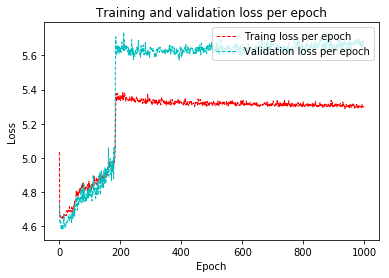

3140/3140 [==============================] - 1s 178us/step
Accuracy = 0.93
Score = 5.46
Area under ROC Curve: 0.928
Matthews correlation coefficient: 0.861
Confusion matrix, without normalization
[[1380  193]
 [  32 1535]]


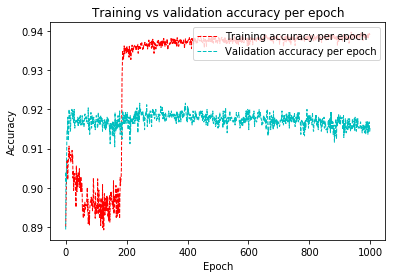

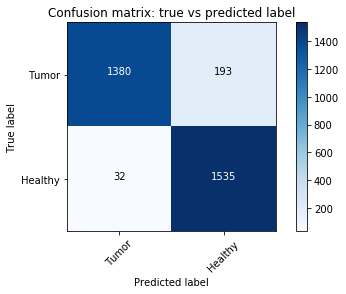

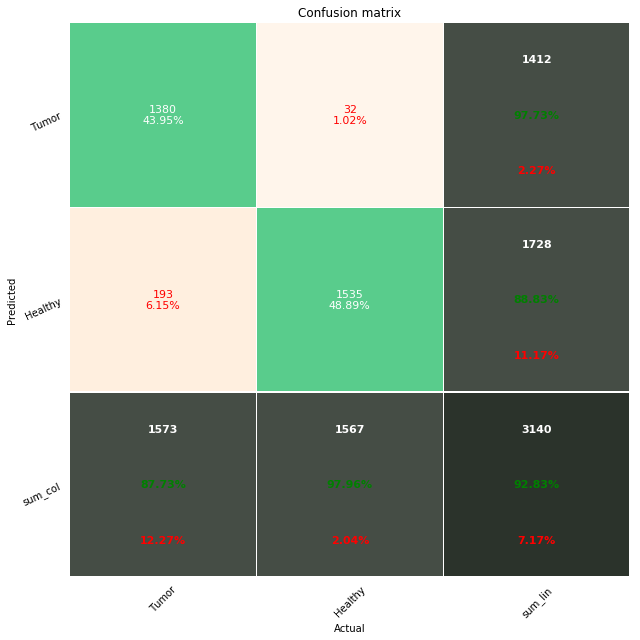

             precision    recall  f1-score   support

      Tumor       0.98      0.88      0.92      1573
    Healthy       0.89      0.98      0.93      1567

avg / total       0.93      0.93      0.93      3140



In [22]:
#cancerClassifier('type', 50, type_features, type_labels) with RMSPro, 1000 iterations
reg = L1L2(l1=0.01, l2=0.01)
cancerClassifier('identification', 1000, risk_features, risk_labels, reg)

X_train shape: (5684, 569)
Y_train shape: (5684, 14)
569
14
Train on 5684 samples, validate on 632 samples
Epoch 1/1000
5684/5684 [==============================] - 15s 3ms/step - loss: 4.5429 - acc: 0.5662 - val_loss: 2.2041 - val_acc: 0.6092
Epoch 2/1000
5684/5684 [==============================] - 14s 2ms/step - loss: 1.7060 - acc: 0.6641 - val_loss: 1.5165 - val_acc: 0.6250
Epoch 3/1000
5684/5684 [==============================] - 14s 2ms/step - loss: 1.2085 - acc: 0.6905 - val_loss: 1.2806 - val_acc: 0.6392
Epoch 4/1000
5684/5684 [==============================] - 14s 2ms/step - loss: 1.0914 - acc: 0.7020 - val_loss: 1.2206 - val_acc: 0.6408
Epoch 5/1000
5684/5684 [==============================] - 15s 3ms/step - loss: 1.0311 - acc: 0.7109 - val_loss: 1.1811 - val_acc: 0.6392
Epoch 6/1000
5684/5684 [==============================] - 15s 3ms/step - loss: 0.9815 - acc: 0.7167 - val_loss: 1.1519 - val_acc: 0.6440
Epoch 7/1000
5684/5684 [==============================] - 14s 2ms/step 

5684/5684 [==============================] - 10s 2ms/step - loss: 0.5093 - acc: 0.8403 - val_loss: 1.0302 - val_acc: 0.6994
Epoch 119/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.5114 - acc: 0.8380 - val_loss: 1.0310 - val_acc: 0.6994
Epoch 120/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.5040 - acc: 0.8415 - val_loss: 1.0298 - val_acc: 0.6994
Epoch 121/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.5098 - acc: 0.8355 - val_loss: 1.0300 - val_acc: 0.7009
Epoch 122/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.5070 - acc: 0.8360 - val_loss: 1.0308 - val_acc: 0.7009
Epoch 123/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.5020 - acc: 0.8378 - val_loss: 1.0321 - val_acc: 0.6994
Epoch 124/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.5010 - acc: 0.8439 - val_loss: 1.0325 - val_acc: 0.7009
Epoch 125/1000
5684/5684 [================

5684/5684 [==============================] - 10s 2ms/step - loss: 0.4665 - acc: 0.8538 - val_loss: 1.0567 - val_acc: 0.6994
Epoch 178/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.4659 - acc: 0.8503 - val_loss: 1.0558 - val_acc: 0.6978
Epoch 179/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.4617 - acc: 0.8489 - val_loss: 1.0562 - val_acc: 0.6978
Epoch 180/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.4585 - acc: 0.8547 - val_loss: 1.0576 - val_acc: 0.6978
Epoch 181/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.4636 - acc: 0.8512 - val_loss: 1.0585 - val_acc: 0.6994
Epoch 182/1000
5684/5684 [==============================] - 11s 2ms/step - loss: 0.4564 - acc: 0.8564 - val_loss: 1.0586 - val_acc: 0.6994
Epoch 183/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.4619 - acc: 0.8527 - val_loss: 1.0594 - val_acc: 0.6994
Epoch 184/1000
5684/5684 [================

5684/5684 [==============================] - 10s 2ms/step - loss: 0.4295 - acc: 0.8649 - val_loss: 1.0820 - val_acc: 0.7009
Epoch 237/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.4292 - acc: 0.8659 - val_loss: 1.0820 - val_acc: 0.6994
Epoch 238/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.4292 - acc: 0.8673 - val_loss: 1.0826 - val_acc: 0.6994
Epoch 239/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.4290 - acc: 0.8638 - val_loss: 1.0822 - val_acc: 0.6994
Epoch 240/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.4303 - acc: 0.8642 - val_loss: 1.0840 - val_acc: 0.7009
Epoch 241/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.4283 - acc: 0.8668 - val_loss: 1.0853 - val_acc: 0.7009
Epoch 242/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.4304 - acc: 0.8651 - val_loss: 1.0859 - val_acc: 0.7009
Epoch 243/1000
5684/5684 [================

5684/5684 [==============================] - 10s 2ms/step - loss: 0.4048 - acc: 0.8735 - val_loss: 1.1095 - val_acc: 0.6994
Epoch 296/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.4052 - acc: 0.8730 - val_loss: 1.1100 - val_acc: 0.6994
Epoch 297/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.4066 - acc: 0.8733 - val_loss: 1.1119 - val_acc: 0.6994
Epoch 298/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.4048 - acc: 0.8724 - val_loss: 1.1133 - val_acc: 0.6994
Epoch 299/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.4040 - acc: 0.8714 - val_loss: 1.1135 - val_acc: 0.6978
Epoch 300/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.4017 - acc: 0.8732 - val_loss: 1.1144 - val_acc: 0.6978
Epoch 301/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.4057 - acc: 0.8691 - val_loss: 1.1157 - val_acc: 0.6978
Epoch 302/1000
5684/5684 [================

5684/5684 [==============================] - 10s 2ms/step - loss: 0.3829 - acc: 0.8816 - val_loss: 1.1372 - val_acc: 0.6994
Epoch 355/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.3882 - acc: 0.8807 - val_loss: 1.1380 - val_acc: 0.7009
Epoch 356/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.3841 - acc: 0.8805 - val_loss: 1.1379 - val_acc: 0.7009
Epoch 357/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.3900 - acc: 0.8761 - val_loss: 1.1387 - val_acc: 0.7009
Epoch 358/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.3830 - acc: 0.8828 - val_loss: 1.1395 - val_acc: 0.6994
Epoch 359/1000
5684/5684 [==============================] - 11s 2ms/step - loss: 0.3865 - acc: 0.8793 - val_loss: 1.1399 - val_acc: 0.6994
Epoch 360/1000
5684/5684 [==============================] - 10s 2ms/step - loss: 0.3830 - acc: 0.8793 - val_loss: 1.1403 - val_acc: 0.6994
Epoch 361/1000
5684/5684 [================

5684/5684 [==============================] - 8s 1ms/step - loss: 0.3604 - acc: 0.8916 - val_loss: 1.1830 - val_acc: 0.7057
Epoch 473/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.3585 - acc: 0.8900 - val_loss: 1.1836 - val_acc: 0.7041
Epoch 474/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.3605 - acc: 0.8872 - val_loss: 1.1852 - val_acc: 0.7041
Epoch 475/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.3578 - acc: 0.8886 - val_loss: 1.1847 - val_acc: 0.7041
Epoch 476/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.3591 - acc: 0.8892 - val_loss: 1.1849 - val_acc: 0.7041
Epoch 477/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.3544 - acc: 0.8892 - val_loss: 1.1857 - val_acc: 0.7057
Epoch 478/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.3594 - acc: 0.8909 - val_loss: 1.1860 - val_acc: 0.7073
Epoch 479/1000
5684/5684 [=======================

5684/5684 [==============================] - 8s 1ms/step - loss: 0.3340 - acc: 0.8973 - val_loss: 1.2263 - val_acc: 0.7089
Epoch 591/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.3330 - acc: 0.8974 - val_loss: 1.2265 - val_acc: 0.7089
Epoch 592/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.3381 - acc: 0.8969 - val_loss: 1.2277 - val_acc: 0.7089
Epoch 593/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.3392 - acc: 0.8971 - val_loss: 1.2277 - val_acc: 0.7089
Epoch 594/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.3368 - acc: 0.8955 - val_loss: 1.2283 - val_acc: 0.7073
Epoch 595/1000
5684/5684 [==============================] - 9s 2ms/step - loss: 0.3380 - acc: 0.8969 - val_loss: 1.2289 - val_acc: 0.7089
Epoch 596/1000
5684/5684 [==============================] - 9s 2ms/step - loss: 0.3356 - acc: 0.8967 - val_loss: 1.2294 - val_acc: 0.7104
Epoch 597/1000
5684/5684 [=======================

5684/5684 [==============================] - 8s 1ms/step - loss: 0.3231 - acc: 0.8995 - val_loss: 1.2632 - val_acc: 0.7073
Epoch 709/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.3201 - acc: 0.9011 - val_loss: 1.2637 - val_acc: 0.7089
Epoch 710/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.3218 - acc: 0.9025 - val_loss: 1.2645 - val_acc: 0.7089
Epoch 711/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.3199 - acc: 0.9017 - val_loss: 1.2647 - val_acc: 0.7089
Epoch 712/1000
5684/5684 [==============================] - 9s 2ms/step - loss: 0.3199 - acc: 0.9024 - val_loss: 1.2656 - val_acc: 0.7089
Epoch 713/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.3206 - acc: 0.9038 - val_loss: 1.2659 - val_acc: 0.7073
Epoch 714/1000
5684/5684 [==============================] - 9s 2ms/step - loss: 0.3187 - acc: 0.9015 - val_loss: 1.2665 - val_acc: 0.7089
Epoch 715/1000
5684/5684 [=======================

5684/5684 [==============================] - 8s 1ms/step - loss: 0.3098 - acc: 0.9034 - val_loss: 1.2995 - val_acc: 0.7089
Epoch 827/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.3114 - acc: 0.9057 - val_loss: 1.2997 - val_acc: 0.7089
Epoch 828/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.3109 - acc: 0.9022 - val_loss: 1.3005 - val_acc: 0.7089
Epoch 829/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.3088 - acc: 0.9059 - val_loss: 1.3016 - val_acc: 0.7089
Epoch 830/1000
5684/5684 [==============================] - 9s 2ms/step - loss: 0.3085 - acc: 0.9076 - val_loss: 1.3024 - val_acc: 0.7073
Epoch 831/1000
5684/5684 [==============================] - 9s 2ms/step - loss: 0.3075 - acc: 0.9045 - val_loss: 1.3020 - val_acc: 0.7089
Epoch 832/1000
5684/5684 [==============================] - 9s 2ms/step - loss: 0.3074 - acc: 0.9073 - val_loss: 1.3017 - val_acc: 0.7089
Epoch 833/1000
5684/5684 [=======================

5684/5684 [==============================] - 8s 1ms/step - loss: 0.2946 - acc: 0.9096 - val_loss: 1.3294 - val_acc: 0.7025
Epoch 945/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.2967 - acc: 0.9110 - val_loss: 1.3307 - val_acc: 0.7025
Epoch 946/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.2994 - acc: 0.9076 - val_loss: 1.3313 - val_acc: 0.7025
Epoch 947/1000
5684/5684 [==============================] - 8s 1ms/step - loss: 0.2998 - acc: 0.9089 - val_loss: 1.3314 - val_acc: 0.7025
Epoch 948/1000
5684/5684 [==============================] - 9s 2ms/step - loss: 0.2953 - acc: 0.9089 - val_loss: 1.3309 - val_acc: 0.7025
Epoch 949/1000
5684/5684 [==============================] - 9s 2ms/step - loss: 0.2963 - acc: 0.9115 - val_loss: 1.3310 - val_acc: 0.7025
Epoch 950/1000
5684/5684 [==============================] - 9s 1ms/step - loss: 0.2990 - acc: 0.9094 - val_loss: 1.3314 - val_acc: 0.7041
Epoch 951/1000
5684/5684 [=======================

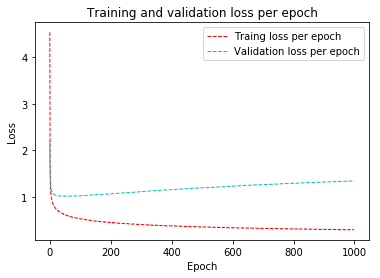

1579/1579 [==============================] - 0s 295us/step
Accuracy = 0.71
Score = 1.17
F-Score: 0.709
Precision: 0.709
Recall: 0.709
F-Score: 0.709
Confusion matrix, without normalization
[[ 75   1   0   0   1   0   0   5   2   1   4   1   6   1]
 [  0  93   0   9   4   0   0   0   1   0   2   2   1   0]
 [  2   0  83   0   1   0   0   1   2   1   9   6   0   1]
 [  3  14   4  58   0   1   0   2   2   0  10   1   0   2]
 [  2   4   2   3  66   2   0   3   4   2   9   2   5   2]
 [  1   0   0   0   7  73   2   0   1  16   2   1   5   4]
 [  0   0   1   0   0   2  95   7   4   1   0   0   1   0]
 [  2   0   1   0   1   0   9  53   8   0  26   0   1   0]
 [  2   0   0   0   8   5   5  10 179   0  11   0   3   3]
 [  1   2   1   2   4  16   0   0   4  61   6   2   4   2]
 [  0   0   1   1   2   0   0   6   3   0  95   6   2   0]
 [  0   1   6   2   1   1   0   0   0   0  15  81   1   0]
 [  9   0   3   1   6   1   0   3   2   1   7   3  51   5]
 [  1   1   0   0   3   5   0   0   2   9   

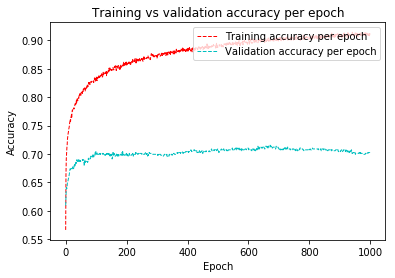

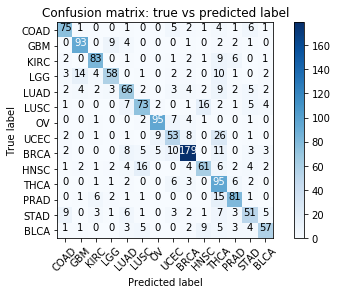

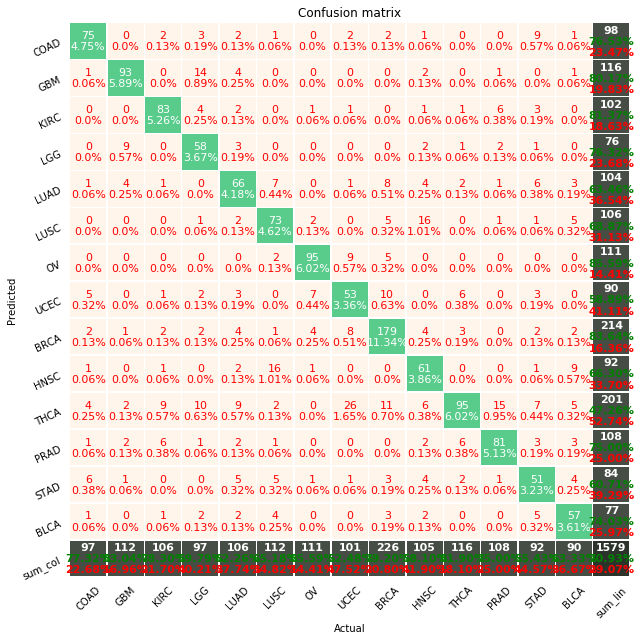

             precision    recall  f1-score   support

       COAD       0.77      0.77      0.77        97
        GBM       0.80      0.83      0.82       112
       KIRC       0.81      0.78      0.80       106
        LGG       0.76      0.60      0.67        97
       LUAD       0.63      0.62      0.63       106
       LUSC       0.69      0.65      0.67       112
         OV       0.86      0.86      0.86       111
       UCEC       0.59      0.52      0.55       101
       BRCA       0.84      0.79      0.81       226
       HNSC       0.66      0.58      0.62       105
       THCA       0.47      0.82      0.60       116
       PRAD       0.75      0.75      0.75       108
       STAD       0.61      0.55      0.58        92
       BLCA       0.74      0.63      0.68        90

avg / total       0.72      0.71      0.71      1579



In [14]:
reg = L1L2(l1=0.01, l2=0.00)
cancerClassifier('type', 1000, type_features, type_labels, reg)

X_train shape: (6316, 569)
Y_train shape: (6316, 14)
569
14
Train on 6316 samples, validate on 2527 samples
Epoch 1/8
6316/6316 [==============================] - 19s 3ms/step - loss: 4.2951 - acc: 0.5788 - val_loss: 1.9762 - val_acc: 0.6597
Epoch 2/8
6316/6316 [==============================] - 18s 3ms/step - loss: 1.5951 - acc: 0.6704 - val_loss: 1.2008 - val_acc: 0.6878
Epoch 3/8
6316/6316 [==============================] - 19s 3ms/step - loss: 1.1759 - acc: 0.6854 - val_loss: 1.0887 - val_acc: 0.7052
Epoch 4/8
6316/6316 [==============================] - 22s 3ms/step - loss: 1.0793 - acc: 0.6984 - val_loss: 1.0208 - val_acc: 0.7103
Epoch 5/8
6316/6316 [==============================] - 33s 5ms/step - loss: 1.0201 - acc: 0.7084 - val_loss: 0.9739 - val_acc: 0.7167
Epoch 6/8
6316/6316 [==============================] - 31s 5ms/step - loss: 0.9740 - acc: 0.7145 - val_loss: 0.9346 - val_acc: 0.7258
Epoch 7/8
6316/6316 [==============================] - 30s 5ms/step - loss: 0.9425 - acc

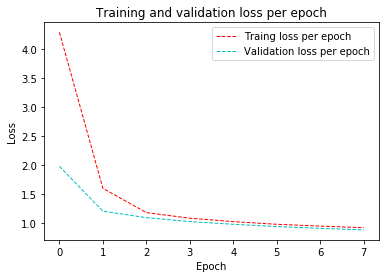

3789/3789 [==============================] - 2s 625us/step
Accuracy = 0.75
Score = 0.85
F-Score: 0.755
Precision: 0.755
Recall: 0.755
F-Score: 0.755
Confusion matrix, without normalization
[[150   1   1   0   3   1   0   2   4   5  22  14  19   1]
 [  0 266   4  21   2   0   0   0   2   0  12   8   3   3]
 [  1   2 219   1   0   0   0   0   2   3  21  30   1   0]
 [  0  25   3 176   4   0   0   0   2   0  24  28   0   1]
 [  0   3   5   1 169  11   0   6  11   2  24  17   6   0]
 [  0   0   0   1  10 175   0   6   5  23   8  12   2   1]
 [  0   1   0   0   0   1 257  12   6   0   2   0   0   0]
 [  2   0   0   0   0   2   5 159  11   0  71   0   4   0]
 [  1   0   3   0   6   3   2  20 435   0  39   0   3   2]
 [  0   2   5   0   8  17   0   1   5 155  13  25  11   2]
 [  0   1   2   0   5   0   0   1   3   0 169  51   0   0]
 [  0   0   0   0   0   0   0   0   1   0   0 247   3   1]
 [  6   0   4   3   2   1   0   4   8   7  24  27 144   4]
 [  0   1   0   1   9   2   0   0   6  10   

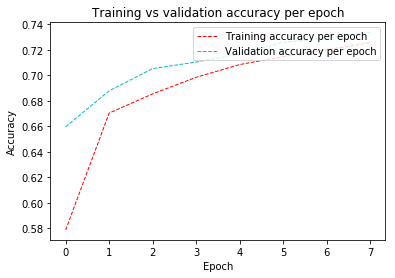

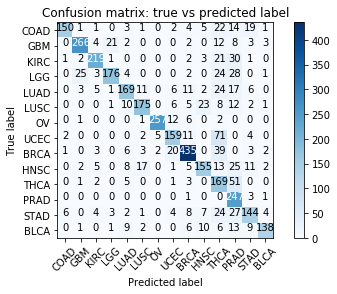

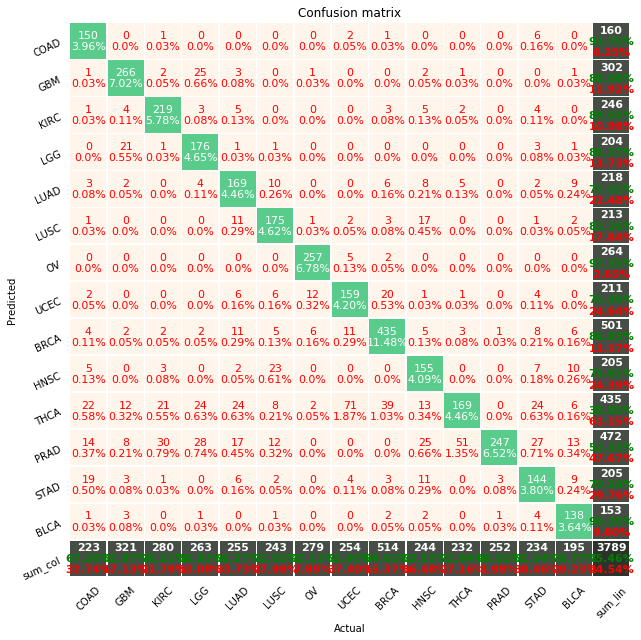

             precision    recall  f1-score   support

       COAD       0.94      0.67      0.78       223
        GBM       0.88      0.83      0.85       321
       KIRC       0.89      0.78      0.83       280
        LGG       0.86      0.67      0.75       263
       LUAD       0.78      0.66      0.71       255
       LUSC       0.82      0.72      0.77       243
         OV       0.97      0.92      0.95       279
       UCEC       0.75      0.63      0.68       254
       BRCA       0.87      0.85      0.86       514
       HNSC       0.76      0.64      0.69       244
       THCA       0.39      0.73      0.51       232
       PRAD       0.52      0.98      0.68       252
       STAD       0.70      0.62      0.66       234
       BLCA       0.90      0.71      0.79       195

avg / total       0.80      0.75      0.76      3789



In [14]:
reg = L1L2(l1=0.01, l2=0.00) #Fake
cancerClassifier('type', 8, type_features, type_labels, reg)